# 🛒 Tydzień 3, Dzień 6: Projekt - Retail Sales Forecasting

To finałowy projekt modułu ML. Zbudujemy system prognozujący sprzedaż w sieci sklepów.

**Cele na dziś:**
1.  **Time Series jako Supervised Learning:** Jak zamienić problem czasu na tabelę cech (Features).
2.  **Date Features:** Wyciąganie "Dnia tygodnia", "Miesiąca" z daty.
3.  **Lags & Rolling:** Tworzenie cech historycznych (np. "Sprzedaż 7 dni temu").
4.  **Temporal Split:** Dlaczego nie wolno tasować danych (Shuffle) przy podziale Train/Test.
5.  **XGBoost Regressor:** Modelowanie i analiza ważności cech.

---
### 🛠️ 1. Instalacja

Używamy `xgboost` oraz standardowego stacku.

In [ ]:
!uv add pandas numpy matplotlib seaborn scikit-learn xgboost

### 🏪 2. Generowanie Danych Sklepowych

Stworzymy realistyczne dane. Sprzedaż zależy od:
*   **Trendu:** Sklep staje się coraz bardziej popularny.
*   **Sezonowości tygodniowej:** W weekendy sprzedaż rośnie.
*   **Promocji:** Gdy jest promocja (0/1), sprzedaż wybucha.
*   **Szumu:** Losowe wahania.

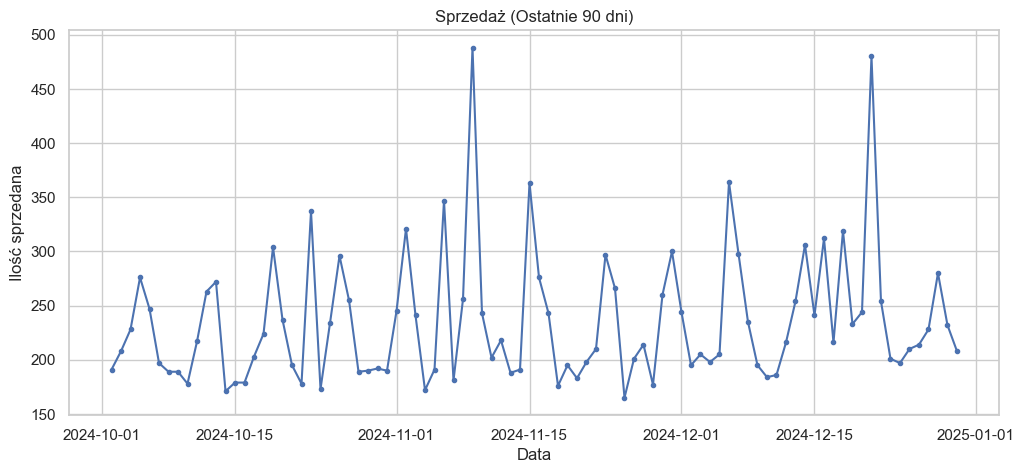

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def create_sales_data():
    np.random.seed(42)
    days = 730 # 2 lata danych
    dates = pd.date_range(start="2023-01-01", periods=days)
    
    # 1. Trend (powolny wzrost liniowy)
    trend = np.linspace(100, 200, days)
    
    # 2. Sezonowość tygodniowa (Weekend Effect)
    # 0=Pon, 6=Niedz. W piątki(4), soboty(5) i niedziele(6) sprzedaż rośnie.
    # Mnożniki: Pon-Czw = 1.0, Pt = 1.2, Sob = 1.5, Nd = 1.3
    week_seasonality = np.array([1.0, 1.0, 1.0, 1.0, 1.2, 1.5, 1.3])
    daily_factors = [week_seasonality[d.dayofweek] for d in dates]
    
    # 3. Promocje (Losowe dni, ok 10% czasu)
    promotions = np.random.choice([0, 1], size=days, p=[0.9, 0.1])
    promo_effect = np.where(promotions == 1, 1.6, 1.0) # +60% sprzedaży w promocji
    
    # 4. Szum (Losowość)
    noise = np.random.normal(0, 15, days)
    
    # Składamy to w całość
    sales = trend * daily_factors * promo_effect + noise
    sales = np.maximum(sales, 0) # Nie może być ujemnej sprzedaży
    
    df = pd.DataFrame({
        "Date": dates,
        "Sales": sales.round(0),
        "Is_Promo": promotions
    })
    
    return df

df = create_sales_data()

# Wizualizacja ostatnich 3 miesięcy
plt.figure(figsize=(12, 5))
subset = df.tail(90)
plt.plot(subset["Date"], subset["Sales"], marker='o', markersize=3)
plt.title("Sprzedaż (Ostatnie 90 dni)")
plt.xlabel("Data")
plt.ylabel("Ilość sprzedana")
plt.show()

### 🧠 3. Feature Engineering (Czas to Pieniądz)

XGBoost nie rozumie daty `2024-01-01`. Musimy mu ją "rozpakować".
Dodatkowo, żeby przewidzieć jutro, musimy wiedzieć co było wczoraj.

Stworzymy:
1.  **Date Features:** Dzień tygodnia, Czy weekend, Miesiąc.
2.  **Lag Features:** Sprzedaż wczoraj (`Lag_1`) i tydzień temu (`Lag_7`). To kluczowe, bo sprzedaż w sobotę zależy od sprzedaży w zeszłą sobotę.
3.  **Rolling Features:** Średnia z ostatnich 7 dni (Trend).

In [2]:
def feature_engineering(df_in):
    df = df_in.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 1. Date Features
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    # Czy to weekend? (Sobota=5, Niedziela=6)
    df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    # 2. Lag Features (Opóźnienia)
    # Co działo się dokładnie tydzień temu?
    df['Sales_Lag_1'] = df['Sales'].shift(1) # Sprzedaż wczoraj
    df['Sales_Lag_7'] = df['Sales'].shift(7) # Sprzedaż 7 dni temu
    
    # 3. Rolling Features (Średnie kroczące)
    # Średnia z ostatniego tygodnia (nie wliczając dzisiaj!)
    # shift(1) jest kluczowy - nie możemy używać dzisiejszej sprzedaży do średniej, bo jej nie znamy!
    df['Sales_Roll_Mean_7'] = df['Sales'].shift(1).rolling(window=7).mean()
    
    # Usuwamy NaN powstałe przez shift (pierwsze 7 dni są bezużyteczne)
    df = df.dropna()
    return df

df_features = feature_engineering(df)
print("✅ Cechy wygenerowane. Podgląd:")
display(df_features.head())

✅ Cechy wygenerowane. Podgląd:


,Date,Sales,Is_Promo,DayOfWeek,Month,Quarter,Is_Weekend,Sales_Lag_1,Sales_Lag_7,Sales_Roll_Mean_7
7,2023-01-08,125.0,0,6,1,1,1,169.0,136.0,132.285714
8,2023-01-09,71.0,0,0,1,1,0,125.0,154.0,130.714286
9,2023-01-10,86.0,0,1,1,1,0,71.0,105.0,118.857143
10,2023-01-11,73.0,0,2,1,1,0,86.0,132.0,116.142857
11,2023-01-12,157.0,1,3,1,1,0,73.0,114.0,107.714286


### ✂️ 4. Temporal Split (Podział w Czasie)

To najważniejsza zasada pracy z szeregami czasowymi.
**NIE WOLNO** używać funkcji `train_test_split(shuffle=True)`.
Nie możemy uczyć modelu na danych z Grudnia, a testować na Styczniu. To byłoby oszustwo (podglądanie przyszłości).

Musimy odciąć końcówkę danych (np. ostatnie 30 dni) jako zbiór testowy.

In [3]:
# Lista cech, których użyje model
features = ['Is_Promo', 'DayOfWeek', 'Month', 'Is_Weekend', 
            'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Roll_Mean_7']
target = 'Sales'

X = df_features[features]
y = df_features[target]

# Ostatnie 30 dni to test
test_days = 30
split_idx = len(df_features) - test_days

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Zachowujemy daty do wykresu
dates_test = df_features['Date'].iloc[split_idx:]

print(f"Trening: {len(X_train)} dni")
print(f"Test:    {len(X_test)} dni")

Trening: 693 dni
Test:    30 dni


### 🤖 5. XGBoost Regressor

Trenujemy model. Użyjemy metryki **MAE (Mean Absolute Error)** - mówi ona, o ile sztuk towaru średnio się mylimy.

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Konfiguracja modelu
model = XGBRegressor(
    n_estimators=500,     # Liczba drzew
    learning_rate=0.05,   # Szybkość nauki
    max_depth=5,          # Głębokość drzewa
    random_state=42,
    n_jobs=-1
)

print("🚀 Trenowanie modelu...")
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Ewaluacja
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- WYNIKI PROGNOZY ---")
print(f"Średni błąd (MAE): {mae:.2f} sztuk")
print(f"Błąd RMSE: {rmse:.2f}")

# BASELINE (Punkt odniesienia)
# Najprostsza prognoza: "Jutro sprzedamy tyle co wczoraj"
baseline_mae = mean_absolute_error(y_test, X_test['Sales_Lag_1'])
print(f"Baseline (Wczorajsza sprzedaż) MAE: {baseline_mae:.2f}")

if mae < baseline_mae:
    print("✅ SUKCES: Model jest lepszy niż naiwna prognoza!")
else:
    print("⚠️ PORAŻKA: Model jest słaby, wróć do Feature Engineering.")

🚀 Trenowanie modelu...

--- WYNIKI PROGNOZY ---
Średni błąd (MAE): 15.79 sztuk
Błąd RMSE: 19.51
Baseline (Wczorajsza sprzedaż) MAE: 56.53
✅ SUKCES: Model jest lepszy niż naiwna prognoza!


### 📊 6. Analiza Wyników

1.  **Wykres:** Zobaczmy, czy model "trafia" w piki sprzedaży.
2.  **Feature Importance:** Co tak naprawdę steruje sprzedażą w naszym sklepie?

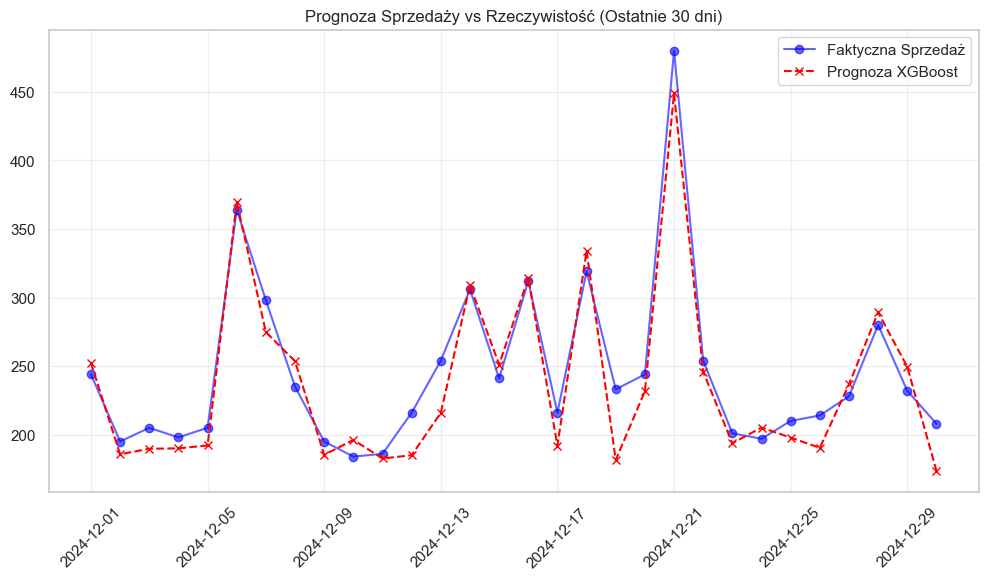

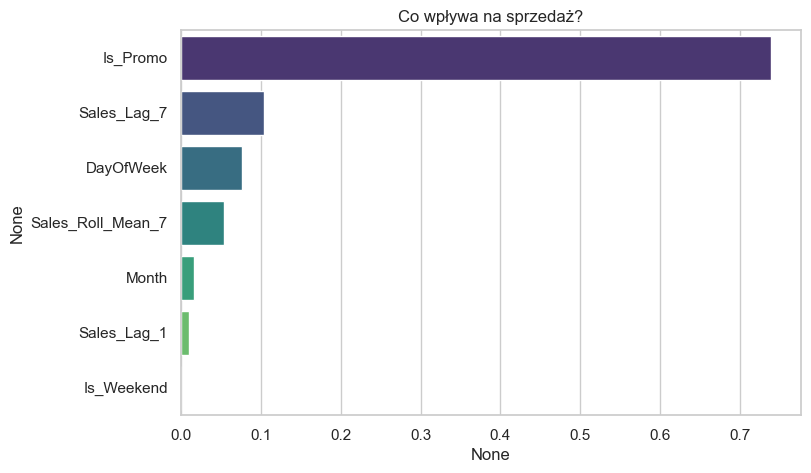

In [8]:
# 1. Wykres Czasowy
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Faktyczna Sprzedaż', color='blue', marker='o', alpha=0.6)
plt.plot(dates_test, y_pred, label='Prognoza XGBoost', color='red', linestyle='--', marker='x')
plt.title("Prognoza Sprzedaży vs Rzeczywistość (Ostatnie 30 dni)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Wykres Ważności Cech
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index, hue=importances.index, palette="viridis", legend=False)
plt.title("Co wpływa na sprzedaż?")
plt.show()

## 🧠 Zadanie Domowe: Optymalizacja (Grid Search)

Nasz model ma parametry wpisane "na czuja". Sprawdźmy, czy da się wycisnąć więcej.

**Zadanie:**
Użyj `GridSearchCV`, aby znaleźć najlepsze parametry dla `XGBRegressor`.
1. Siatka parametrów:
   ```python
   param_grid = {
       'n_estimators': [100, 500],
       'learning_rate': [0.01, 0.1],
       'max_depth': [3, 5]
   }

In [9]:
from sklearn.model_selection import GridSearchCV

print("--- ZADANIE DOMOWE: OPTYMALIZACJA HIPERPARAMETRÓW ---")

# 1. Siatka parametrów do sprawdzenia
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5]
}

# 2. Model bazowy
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

# 3. Konfiguracja Grid Search
# cv=3 -> 3-krotna walidacja krzyżowa
# scoring='neg_mean_absolute_error' -> Sklearn maksymalizuje wynik, więc błąd musi być ujemny
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3, 
    verbose=1
)

print("⏳ Rozpoczynam przeszukiwanie siatki (to może chwilę potrwać)...")
grid_search.fit(X_train, y_train)

# 4. Najlepsze wyniki
print("\n🏆 Najlepsze parametry:")
print(grid_search.best_params_)

# 5. Ewaluacja zwycięzcy na zbiorze testowym
best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test)
mae_opt = mean_absolute_error(y_test, y_pred_opt)

print(f"\n📉 MAE (Zoptymalizowany): {mae_opt:.2f}")
print(f"📉 MAE (Poprzedni):       {mae:.2f}") # Zmienna 'mae' z poprzednich komórek

if mae_opt < mae:
    print("✅ SUKCES: Optymalizacja poprawiła wynik!")
else:
    print("😐 Wynik podobny lub gorszy (może poprzednie parametry były już trafione).")

--- ZADANIE DOMOWE: OPTYMALIZACJA HIPERPARAMETRÓW ---
⏳ Rozpoczynam przeszukiwanie siatki (to może chwilę potrwać)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🏆 Najlepsze parametry:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

📉 MAE (Zoptymalizowany): 14.97
📉 MAE (Poprzedni):       15.79
✅ SUKCES: Optymalizacja poprawiła wynik!
